In [1]:
import torch
from torchvision import datasets, transforms

# Define Transform
transform = transforms.Compose([
transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

trainset = datasets.FashionMNIST('~/.pytorhc/F_MNIST_data/', download=True, train=True, transform= transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)

testset = datasets.FashionMNIST('~/.pytorhc/F_MNIST_data/', download=True, train=False, transform= transform)
testloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)

0it [00:00, ?it/s]

26427392it [00:23, 1980896.19it/s]                              

Extracting /Users/slava/.pytorhc/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /Users/slava/.pytorhc/F_MNIST_data/FashionMNIST/raw


Extracting /Users/slava/.pytorhc/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /Users/slava/.pytorhc/F_MNIST_data/FashionMNIST/raw


Extracting /Users/slava/.pytorhc/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /Users/slava/.pytorhc/F_MNIST_data/FashionMNIST/raw


Extracting /Users/slava/.pytorhc/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/slava/.pytorhc/F_MNIST_data/FashionMNIST/raw
Processing...
Done!


/Users/slava/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1607370249289/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
26427392it [00:40, 1980896.19it/s]


In [2]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
    
    def forward(self, x):
        # flatten input tensor
        x = x.view(x.shape[0], -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim = 1)

        return x

model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)

model

Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)

In [3]:
images, labels  = next(iter(testloader))
ps = torch.exp(model(images))

print(ps.shape)

torch.Size([64, 10])


In [14]:
top_p, top_class = ps.topk(1, dim=1)
print(top_class[:10,:])
print(top_p[:10, :])

tensor([[2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2]])
tensor([[0.1124],
        [0.1127],
        [0.1123],
        [0.1094],
        [0.1140],
        [0.1123],
        [0.1122],
        [0.1097],
        [0.1100],
        [0.1130]], grad_fn=<SliceBackward>)


In [16]:
#Training

epochs = 20
steps = 0

train_losses, test_losses = [], []

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()

        logps = model(images)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0

        with torch.no_grad():
            #validation_pass here
            for images,labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epochs: {}/{}".format(e+1, epochs))
        print("Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epochs: 1/20
Test Accuracy: 0.846
Epochs: 2/20
Test Accuracy: 0.863
Epochs: 3/20
Test Accuracy: 0.882
Epochs: 4/20
Test Accuracy: 0.886
Epochs: 5/20
Test Accuracy: 0.886
Epochs: 6/20
Test Accuracy: 0.895
Epochs: 7/20
Test Accuracy: 0.897
Epochs: 8/20
Test Accuracy: 0.905
Epochs: 9/20
Test Accuracy: 0.906
Epochs: 10/20
Test Accuracy: 0.906
Epochs: 11/20
Test Accuracy: 0.910
Epochs: 12/20
Test Accuracy: 0.912
Epochs: 13/20
Test Accuracy: 0.907
Epochs: 14/20
Test Accuracy: 0.913
Epochs: 15/20
Test Accuracy: 0.912
Epochs: 16/20
Test Accuracy: 0.923
Epochs: 17/20
Test Accuracy: 0.921
Epochs: 18/20
Test Accuracy: 0.926
Epochs: 19/20
Test Accuracy: 0.924
Epochs: 20/20
Test Accuracy: 0.922


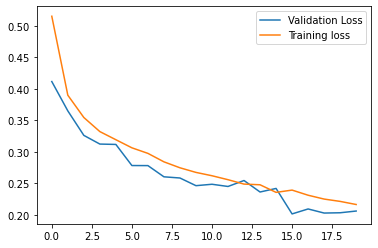

In [19]:
import matplotlib.pyplot as plt
plt.plot(test_losses, label = "Validation Loss")
plt.plot(train_losses, label = "Training loss")
plt.legend()

In [38]:
# Adding Dropout layers

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, x):
        # flatten input tensor
        x = x.view(x.shape[0], -1)

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim = 1)

        return x

model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)

model


Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [39]:
#Training

epochs = 30
steps = 0

train_losses, test_losses = [], []

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()

        logps = model(images)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0

        with torch.no_grad():
            model.eval()
            #validation_pass here
            for images,labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epochs: {}/{}".format(e+1, epochs))
        print("Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epochs: 1/30
Test Accuracy: 0.845
Epochs: 2/30
Test Accuracy: 0.841
Epochs: 3/30
Test Accuracy: 0.860
Epochs: 4/30
Test Accuracy: 0.872
Epochs: 5/30
Test Accuracy: 0.869
Epochs: 6/30
Test Accuracy: 0.881
Epochs: 7/30
Test Accuracy: 0.885
Epochs: 8/30
Test Accuracy: 0.882
Epochs: 9/30
Test Accuracy: 0.879
Epochs: 10/30
Test Accuracy: 0.879
Epochs: 11/30
Test Accuracy: 0.891
Epochs: 12/30
Test Accuracy: 0.890
Epochs: 13/30
Test Accuracy: 0.889
Epochs: 14/30
Test Accuracy: 0.884
Epochs: 15/30
Test Accuracy: 0.894
Epochs: 16/30
Test Accuracy: 0.898
Epochs: 17/30
Test Accuracy: 0.896
Epochs: 18/30
Test Accuracy: 0.896
Epochs: 19/30
Test Accuracy: 0.892
Epochs: 20/30
Test Accuracy: 0.899
Epochs: 21/30
Test Accuracy: 0.901
Epochs: 22/30
Test Accuracy: 0.901
Epochs: 23/30
Test Accuracy: 0.898
Epochs: 24/30
Test Accuracy: 0.903
Epochs: 25/30
Test Accuracy: 0.906
Epochs: 26/30
Test Accuracy: 0.909
Epochs: 27/30
Test Accuracy: 0.903
Epochs: 28/30
Test Accuracy: 0.894
Epochs: 29/30
Test Accuracy: 

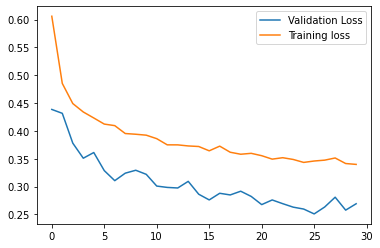

In [40]:
plt.plot(test_losses, label = "Validation Loss")
plt.plot(train_losses, label = "Training loss")
plt.legend()

Saving Model

In [41]:
print("Out model: \n\n ", model, "\n")
print("State dict keys: \n\n", model.state_dict().keys())

Out model: 

  Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
) 

State dict keys: 

 odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])


In [42]:
torch.save(model.state_dict(), 'first_Model.pth')

In [43]:
state_dict = torch.load('first_Model.pth')
print(state_dict.keys())

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])


In [44]:
checkpoint = {'input_size': 784,
                'output_size': 10,
                'hidden_layers': [256, 128, 64, 10],
                'state_dict': model.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

Load Model

In [46]:
import fc_model
checkpoint = torch.load('checkpoint.pth')
new_model = Classifier()
new_model.load_state_dict(checkpoint['state_dict'])
print(new_model)

Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [47]:
torch.cuda.is_available()

False